# Z3 SAT Exercises

> Before trying to solve the exercises contained in this notebook, the reader is suggested to have gained experience with the tool through the `Tutorial.ipynb` notebook.

In [201]:
from itertools import combinations
from z3 import *
from utils import *

## Useful contraints

In [141]:
def at_least_one(bool_vars):
    return Or(bool_vars)

def at_most_one(bool_vars):
    return [Not(And(pair[0], pair[1])) for pair in combinations(bool_vars, 2)]

def exactly_one(solver, bool_vars):
    solver.add(at_most_one(bool_vars))
    solver.add(at_least_one(bool_vars))

## Pigeonhole principle

In mathematics, the pigeonhole principle states that if $n$ items are put into $m$ containers, with $n > m$, then at least one container must contain more than one item.

In [129]:
def pigeon_hole_sat(n, m, enforce_condition = True):
    if enforce_condition:
        assert n>m, print("Input is not compatible with the problem, n must be bigger than m.")
    #Create the variables, x_i_j = 1 iff pigeon i is in hole j.
    p = [[Bool(f"x_{i}_{j}") for j in range(m)] for i in range(n)]
    
    #Solver instance
    s = Solver()
    
    #Each pigeon must be in at least one container
    for i in range(n):
        s.add(at_least_one(p[i]))
    
    #Each container must contain at most one pigeon
    for k in range(m):
        s.add(at_most_one([p[i][k] for i in range(n)]))
        
    if s.check() == sat:
        model = s.model()
        return [j for i in range(n) for j in range(m) if model.evaluate(p[i][j])]
    else:
        return "Unsat" 

In [ ]:
instance1 = {"m":5, "n":6}
instance2 = {"m":10, "n":9} 

if we place $m=n + 1$ pigeons in $n$ holes then there is a hole with at least 2 pigeons The theorem holds true for any $n$, but we can prove it for a fixed $n$.

We are going to use <b>z3 + SAT</b> to prove this theorem by absurd.

In [130]:
print(pigeon_hole_sat(instance1["n"], instance1["m"]))

Unsat


Of course, if $n<m$, the problem is Satisfiable and we can obtain a result.

In [134]:
%%time
display_pigeons(pigeon_hole_sat(instance2["n"], instance2["m"], enforce_condition = False), instance2["m"])

[🕊] [🕊] [🕊] [🕊] [🕊] [🕊] [🕊] [🕊] [🕊] [.] 
CPU times: user 109 ms, sys: 4.05 ms, total: 113 ms
Wall time: 116 ms


## Coloring graph

Another famous problem is the coloring graph. 

Given a graph $({v_1,...,v_n},E)$ and $d$ colors, we need to assign a color to each vertex, s.t. if $(v_i,v_j) ∈ E$ then color of $v_i$ is different from color of $v_j$. 

In [205]:
def coloring_graph_sat(n, d, E, use_at_most = True):
    #Create the variables, x_i_j = 1 iff vertex i is colored with color j.
    p = [[Bool(f"x_{i}_{j}") for j in range(d)] for i in range(n)]
    
    #Solver instance
    s = Solver()
    
    #Each vertex has at least one color 
    for i in range(n):
        s.add(at_least_one(p[i]))
    
    #Each edge must have different colors in its vertices
    for i, j in E:
        for k in range(d):
            s.add(Or(Not(p[i][k]), Not(p[j][k])))
    
    if use_at_most:
    #Each vertex has at most one color
        for i in range(n):
            s.add(at_most_one(p[i]))
    
    s.check()
    m = s.model()
    
    return [(i, j) for i in range(n) for j in range(d) if m.evaluate(p[i][j])]    

In [206]:
instance1 = {
        "n" : 5,
        "d": 3,
        "E" : [
            (0, 2),
            (0, 4),
            (1, 2),
            (1, 4),
            (2, 3), 
            (3, 4)
        ]
    }
instance2 = {
        "n":10,
        "d":3,
        "E":[
            (0, 1),
            (0, 4),
            (0, 5),
            (1, 2),
            (1, 6),
            (2, 7),
            (2, 3),
            (3, 8),
            (3, 4),
            (4, 9),
            (9, 6),
            (9, 7),
            (6, 8),
            (5, 7),
            (5, 8), 
        ]
}

In [207]:
instance = instance1

None
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


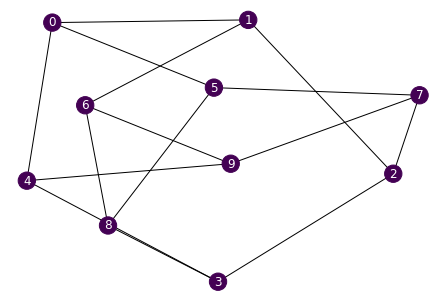

In [208]:
display_color_graph(E = instance["E"])

[(0, 0), (1, 2), (2, 0), (3, 2), (4, 1), (5, 2), (6, 1), (7, 1), (8, 0), (9, 0)]
[0.9804570627279737, 0.692117291762397, 0.945240054800774, 0.692117291762397, 0.9804570627279737, 0.945240054800774, 0.945240054800774, 0.692117291762397, 0.9804570627279737, 0.9804570627279737]
CPU times: user 98.6 ms, sys: 8.19 ms, total: 107 ms
Wall time: 119 ms


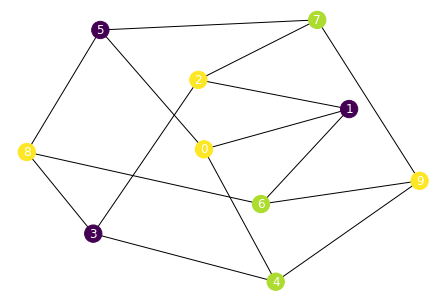

In [209]:
%%time
display_color_graph(sol = coloring_graph_sat(instance["n"], instance["d"], instance["E"]), E = instance["E"])

## N-Queens

In [135]:
def nqueens_sat(n):
    # Create all the variables
    p = [[Bool(f"x_{i}_{j}") for j in range(n)] for i in range(n)]

    # Create the solver instance
    s = Solver()

    # At least one on each row and column
    for i in range(n):
        s.add(at_least_one(p[i]))
        s.add(at_least_one([p[j][i] for j in range(n)]))

    # At most one on each row and column
    for i in range(n):
        col_i = []
        for j in range(n):
            col_i += [p[j][i]]
        s.add(at_most_one(p[i]))
        s.add(at_most_one(col_i))

    # Add the diagonal constraints
    for i in range(n - 1):
        diag_ru = []
        diag_lu = []
        diag_rl = []
        diag_ll = []
        for j in range(n - i):
            diag_ru += [p[i + j][j]]
            diag_lu += [p[n - 1 - (i + j)][j]]
            diag_rl += [p[i + j][n - 1 - j]]
            diag_ll += [p[n - 1 - (i + j)][n - 1 - j]]
        s.add(at_most_one(diag_ru))
        s.add(at_most_one(diag_lu))
        s.add(at_most_one(diag_rl))
        s.add(at_most_one(diag_ll))

    s.check()

    m = s.model()
    return [(i, j) for i in range(n) for j in range(n) if m.evaluate(p[i][j])]

In [136]:
%%time
display_nqueens(nqueens_sat(20))

. . . . . . . . . . ♛ . . . . . . . . . 
. . . . . . . . . . . . . . . . ♛ . . . 
. . . . . . . . . . . . . . ♛ . . . . . 
. . . . . . . . . . . . ♛ . . . . . . . 
. . . . . . . . . . . . . . . ♛ . . . . 
. . . . . . . . . . . . . ♛ . . . . . . 
. . . . . . . . ♛ . . . . . . . . . . . 
. . . . . . ♛ . . . . . . . . . . . . . 
♛ . . . . . . . . . . . . . . . . . . . 
. . . ♛ . . . . . . . . . . . . . . . . 
. ♛ . . . . . . . . . . . . . . . . . . 
. . . . . . . . . . . . . . . . . ♛ . . 
. . . . . . . . . . . . . . . . . . . ♛ 
. . . . . . . . . ♛ . . . . . . . . . . 
. . . . . . . . . . . ♛ . . . . . . . . 
. . . . . . . . . . . . . . . . . . ♛ . 
. . . . . ♛ . . . . . . . . . . . . . . 
. . . . . . . ♛ . . . . . . . . . . . . 
. . ♛ . . . . . . . . . . . . . . . . . 
. . . . ♛ . . . . . . . . . . . . . . . 
CPU times: user 2.45 s, sys: 26.3 ms, total: 2.47 s
Wall time: 2.53 s


## Sudoku

In [137]:
# Sudoku instances, '0's correspond to empty cells

instance1 = ((0, 0, 0, 0, 9, 4, 0, 3, 0),
             (0, 0, 0, 5, 1, 0, 0, 0, 7),
             (0, 8, 9, 0, 0, 0, 0, 4, 0),
             (0, 0, 0, 0, 0, 0, 2, 0, 8),
             (0, 6, 0, 2, 0, 1, 0, 5, 0),
             (1, 0, 2, 0, 0, 0, 0, 0, 0),
             (0, 7, 0, 0, 0, 0, 5, 2, 0),
             (9, 0, 0, 0, 6, 5, 0, 0, 0),
             (0, 4, 0, 9, 7, 0, 0, 0, 0))

instance2 = ((0, 0, 0, 0, 9, 0, 1, 0, 0),
             (2, 8, 0, 0, 0, 5, 0, 0, 0),
             (7, 0, 0, 0, 0, 6, 4, 0, 0),
             (8, 0, 5, 0, 0, 3, 0, 0, 6),
             (0, 0, 1, 0, 0, 4, 0, 0, 0),
             (0, 7, 0, 2, 0, 0, 0, 0, 0),
             (3, 0, 0, 0, 0, 1, 0, 8, 0),
             (0, 0, 0, 0, 0, 0, 0, 5, 0),
             (0, 9, 0, 0, 0, 0, 0, 7, 0))

instance3 = ((0, 7, 0, 0, 0, 0, 0, 4, 9),
             (0, 0, 0, 4, 0, 0, 0, 0, 0),
             (4, 0, 3, 5, 0, 7, 0, 0, 8),
             (0, 0, 7, 2, 5, 0, 4, 0, 0),
             (0, 0, 0, 0, 0, 0, 8, 0, 0),
             (0, 0, 4, 0, 3, 0, 5, 9, 2),
             (6, 1, 8, 0, 0, 0, 0, 0, 5),
             (0, 9, 0, 1, 0, 0, 0, 3, 0),
             (0, 0, 5, 0, 0, 0, 0, 0, 7))

instance4 = ((0, 0, 0, 0, 0, 6, 0, 0, 0),
             (0, 5, 9, 0, 0, 0, 0, 0, 8),
             (2, 0, 0, 0, 0, 8, 0, 0, 0),
             (0, 4, 5, 0, 0, 0, 0, 0, 0),
             (0, 0, 3, 0, 0, 0, 0, 0, 0),
             (0, 0, 6, 0, 0, 3, 0, 5, 4),
             (0, 0, 0, 3, 2, 5, 0, 0, 6),
             (0, 0, 0, 0, 0, 0, 0, 0, 0),
             (0, 0, 0, 0, 0, 0, 0, 0, 0))

In [138]:
def sudoku_sat(instance):
    # All the variables we need: for each cell, nine variables that determine which digit must be assigned.
    v = [[[Bool(f"v_{i}_{j}_{k}") for k in range(9)] for j in range(9)] for i in range(9)]

    s = Solver()

    # A cell has only one value
    for i in range(9):
        for j in range(9):
            exactly_one(s, v[i][j])

    # Each value is used only once in a row
    for j in range(9):
        for k in range(9):
            exactly_one(s, [v[i][j][k] for i in range(9)])

    # Each value used exactly once in each column
    for i in range(9):
        for k in range(9):
            exactly_one(s, [v[i][j][k] for j in range(9)])

    # Each value used exactly once in each 3x3 grid.
    for ii in range(3):
        for jj in range(3):
            for k in range(9):
                grid_cells = [v[3 * ii + a][3 * jj + b][k] for a in range(3) for b in range(3)]
                exactly_one(s, grid_cells)

    # Some numbers are already available
    for i in range(9):
        for j in range(9):
            if instance[i][j] > 0:
                s.add(v[i][j][instance[i][j] - 1])

    if s.check() == sat:
        m = s.model()
        sol = []
        for i in range(9):
            sol.append([])
            for j in range(9):
                for k in range(9):
                    if m.evaluate(v[i][j][k]):
                        sol[i].append(k+1)
        return sol
    else:
        print("Failed to solve")

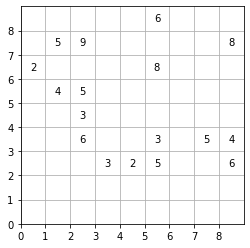

In [139]:
# Select the instance you want to solve
instance = instance4
display_sudoku(instance)

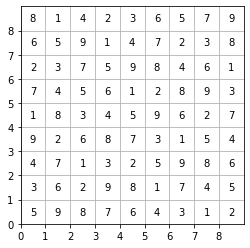

CPU times: user 2.77 s, sys: 60.9 ms, total: 2.83 s
Wall time: 2.93 s


In [142]:
%%time
display_sudoku(sudoku_sat(instance))

## Nurse scheduling problem

In the next example, a hospital supervisor needs to create a schedule for four nurses over a three-day period, subject to the following conditions:

- Each day is divided into three 8-hour shifts.
- Every day, each shift is assigned to a single nurse, and no nurse works more than one shift.
- Each nurse is assigned to at least two shifts during the three-day period.


In [214]:
instance = {
    "num_nurses" : 4,
    "num_shifts" : 3,
    "num_days" : 3
}

In [257]:
def at_least_k(bool_vars, k):
    constraints = []
    for i in range(k, len(bool_vars) + 1):
        constraints+=[And([Not(var) if var not in pair else var for var in bool_vars]) for pair in combinations(bool_vars, i)]  
    return Or(constraints)

def at_most_k(bool_vars, k):
    constraints = []
    for i in range(k):
        constraints+=[And([Not(var) if var not in pair else var for var in bool_vars]) for pair in combinations(bool_vars, i + 1)]  
    return Or(constraints)

def exactly_k(bool_vars, k):
    return Or([And([Not(var) if var not in pair else var for var in bool_vars]) for pair in combinations(bool_vars, k)])

## Try it yourself!

In [259]:
def nurse_scheduling_sat(num_nurses, num_shifts, num_days):
    # Create all the variables, shifts[i, j, k] is True if shift k is assigned to nurse i on day j.
    shifts = [[[Bool(f"x_{i}_{j}_{k}") for k in range(num_shifts)] for j in range(num_days)] for i in range(num_nurses)]

    s = Solver()
    
    # In each shift can work just one nurse 
    for j in range(num_days):
        for k in range(num_shifts):
            exactly_one(s, [shifts[i][j][k] for i in range(num_nurses)])
    
    
    # Each nurse can work one shift per day
    for i in range(num_nurses):
        for j in range(num_days):
            s.add(at_most_one(shifts[i][j]))
            
    # Try to distribute the shifts evenly, so that each nurse works
    # min_shifts_per_nurse shifts. If this is not possible, because the total
    # number of shifts is not divisible by the number of nurses, some nurses will
    # be assigned one more shift.
    min_shifts_per_nurse = (num_shifts * num_days) // num_nurses
    if num_shifts * num_days % num_nurses == 0:
        max_shifts_per_nurse = min_shifts_per_nurse
    else:
        max_shifts_per_nurse = min_shifts_per_nurse + 1
    for i in range(num_nurses):
        shifts_worked = []
        for j in range(num_days):
            for k in range(num_shifts):
                shifts_worked.append(shifts[i][j][k])
        s.add(at_least_k(shifts_worked, min_shifts_per_nurse))
        s.add(at_most_k(shifts_worked, max_shifts_per_nurse))
    
    s.check()
    
    if s.check() == sat:
        m = s.model()
        #print(m.evaluate([shifts[i][j][k] ]))
        return [(i, j, k) for i in range(num_nurses) for j in range(num_days) for k in range(num_shifts) if m.evaluate(shifts[i][j][k])]
    else:
        return "Unsat"     

In [262]:
%%time
display_nurses_shifts(nurse_scheduling_sat(instance["num_nurses"], instance["num_shifts"], instance["num_days"]), instance["num_nurses"], instance["num_shifts"], instance["num_days"])

Day 0
  Nurse 0 works shift 1
  Nurse 1 works shift 2
  Nurse 2 works shift 0
  Nurse 3 does not work
Day 1
  Nurse 0 works shift 0
  Nurse 1 works shift 2
  Nurse 2 does not work
  Nurse 3 works shift 1
Day 2
  Nurse 0 works shift 2
  Nurse 1 does not work
  Nurse 2 works shift 1
  Nurse 3 works shift 0
CPU times: user 15.9 s, sys: 152 ms, total: 16.1 s
Wall time: 17.4 s
